# Classifying Wine Variety 
Using Price, Rating Points and other Text Columns

In [376]:
#importing Libraries
import pandas as pd
from scipy import sparse
import numpy as np
import seaborn as sns
     
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer    
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn import preprocessing
from scipy.sparse import hstack

In [377]:
# Reading Data Set
data = pd.read_csv("train.csv")

## Descriptive Statistics

In [378]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
user_name             63264 non-null object
country               82622 non-null object
review_title          82657 non-null object
review_description    82657 non-null object
designation           59010 non-null object
points                82657 non-null int64
price                 77088 non-null float64
province              82622 non-null object
region_1              69903 non-null object
region_2              35949 non-null object
winery                82657 non-null object
variety               82657 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [379]:
# 5 n0. Summary of prices and points column
data.describe()

,points,price
count,82657.000000,77088.000000
mean,88.544564,36.922232
std,3.099649,43.698346
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,45.000000
max,100.000000,3300.000000


* Average Price of 1 bottle of wine is 36$
* Average Score points given to all wine variety is 88.5

In [380]:
# Average Price Based on Each Variety
ast = data.groupby('variety')[["price"]].mean().reset_index()
ast = ast.sort_values(['price'], ascending=False)

Text(0.5, 1.0, 'Average Prices Of Diffrent varieties of Wine')

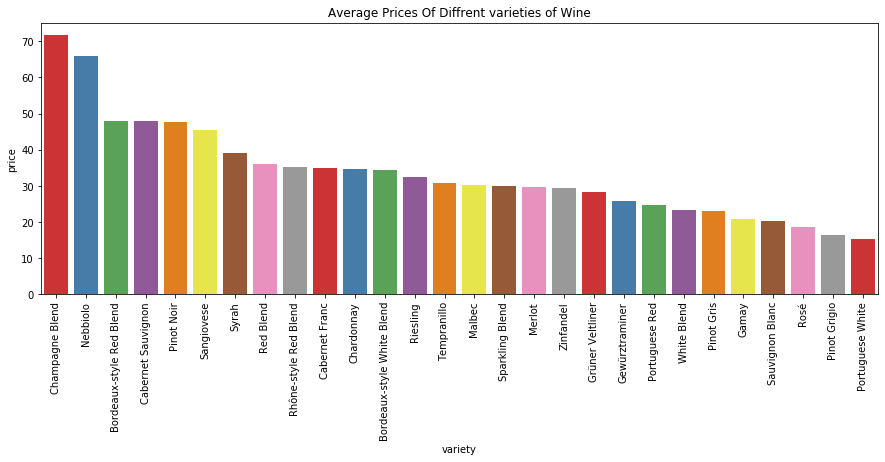

In [381]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="variety", y="price", data=ast,palette='Set1')
c=ax.get_xticklabels()
d = ax.set_xticklabels(c, rotation=90)
plt.title("Average Prices Of Diffrent varieties of Wine")

In [382]:
# Average Price Based on Each country
ast = data.groupby('country')[["price"]].mean().reset_index()
ast = ast.sort_values(['price'], ascending=False)

Text(0.5, 1.0, 'Average Prices Of Wine based on its country')

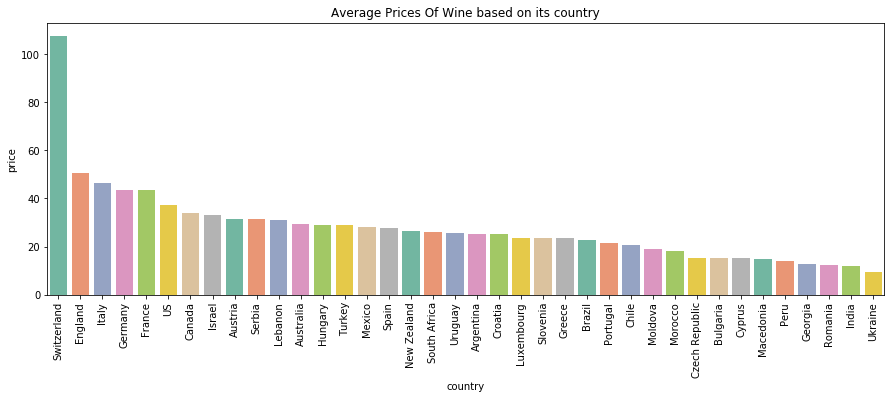

In [383]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="country", y="price", data=ast,palette='Set2')
c=ax.get_xticklabels()
d = ax.set_xticklabels(c, rotation=90)
plt.title("Average Prices Of Wine based on its country")

In [384]:
# Average Price Based on Each province
ast = data.groupby('province')[["price"]].mean().reset_index()
ast = ast.sort_values(['price'], ascending=False)

Text(0.5, 1.0, 'Top 10 Average Prices Of Wine based on its Province')

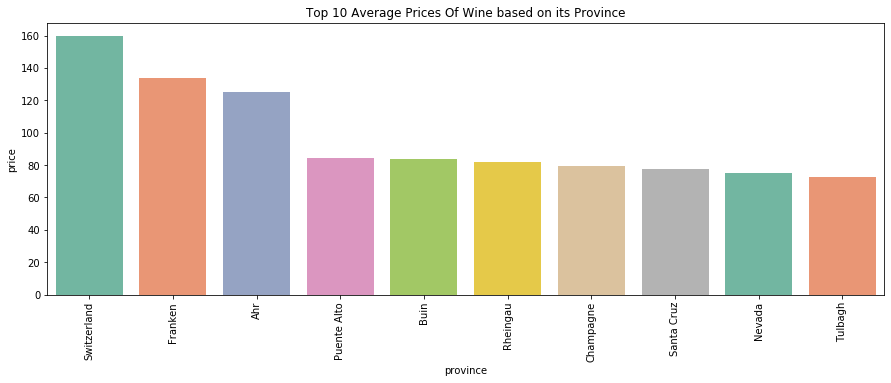

In [385]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="province", y="price", data=ast.iloc[0:10,:],palette='Set2')
c=ax.get_xticklabels()
d = ax.set_xticklabels(c, rotation=90)
plt.title("Top 10 Average Prices Of Wine based on its Province")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000160A653E0B8>,
      dtype=object)

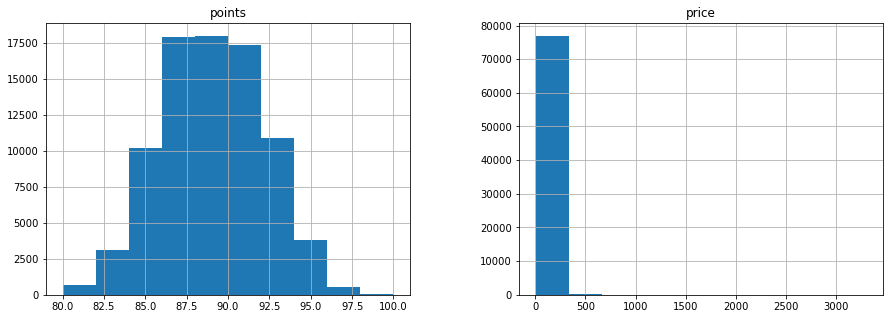

In [386]:
#plotting distribution of Points
plt.ffigsize=(15,5)
data.hist(figsize=(15,5))

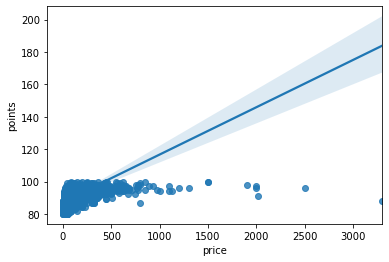

In [387]:
#Scatter plot of price and points Columns
ax = sns.regplot(x="price", y="points", data=data)

* We can see a slight Increasing Trend which suggests that higher score leads to high price of the wine

## Data Preprocessing

In [388]:
#Reading Test Set
data2 = pd.read_csv("test.csv")
#Adding unknown Variety in text column
data2["variety"] = "unknown"

In [389]:
#Joining Train And Test Data
full = pd.concat([data,data2])
full.reset_index(drop=True,inplace=True)

In [390]:
full.variety.value_counts()

unknown                       20665
Pinot Noir                    10587
Chardonnay                     9403
Cabernet Sauvignon             7552
Red Blend                      7166
Bordeaux-style Red Blend       5497
Riesling                       4148
Sauvignon Blanc                4011
Syrah                          3316
Rosé                           2831
Merlot                         2471
Nebbiolo                       2242
Zinfandel                      2209
Sangiovese                     2165
Malbec                         2119
Portuguese Red                 1969
White Blend                    1896
Sparkling Blend                1739
Tempranillo                    1448
Rhône-style Red Blend          1182
Pinot Gris                     1148
Champagne Blend                1133
Cabernet Franc                 1095
Grüner Veltliner               1055
Portuguese White                896
Pinot Grigio                    873
Bordeaux-style White Blend      850
Gewürztraminer              

In [391]:
#Looking For NAs
miss = pd.DataFrame(full.isnull().sum())
miss = miss.rename(columns={0:"miss_count"})
miss["miss_%"] = (miss.miss_count/len(full.iloc[:,0]))*100
miss

,miss_count,miss_%
user_name,24131,23.355142
country,39,0.037746
review_title,0,0.000000
review_description,0,0.000000
designation,29636,28.683146
points,0,0.000000
price,6963,6.739126
province,39,0.037746
region_1,16068,15.551383
region_2,58459,56.579431


* We can see that the numerical column has 6% values missing.

In [392]:
#the funtion performs all the important preprocessing steps 
def preprocess(df):
    #combinig all text columns
    df['all_text']= df["review_title"].astype(str) +" "+ df["review_description"].astype(str) +" "+ df["designation"].astype(str) +" "+ df["province"].astype(str)+" "+ df["region_1"].astype(str) +" "+ df["region_2"].astype(str) +" "+ df["winery"].astype(str)
    
    #tokenizer to remove unwanted elements from out data like symbols and numbers
    token = RegexpTokenizer(r'[a-zA-Z]+')
    
    # converting Countvector from the text
    cv = CountVectorizer(lowercase=True,stop_words='english',min_df=400,ngram_range = (1,1),tokenizer = token.tokenize)
    text_counts= cv.fit_transform(df['all_text'])
    
    #Imputing NAs in the price colums
    df['price'] = df['price'].fillna(df['price'].mean())
    df['points'] = df['points'].fillna(df['points'].mean())
    
    # Scaling Numerical variables 
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # converting our data frame into matrix
    df1 = df[["price","points"]].astype(np.float)
    df1 =np.nan_to_num(df1)
    
    # applying scaler on our data and coverting i into a data frame
    df_minmax = pd.DataFrame((scaler.fit_transform(df1)))
    df_minmax.columns = ["price","points"]
    
    #Adding our Price and points Variables in the count vector
    prices = df_minmax.price.values[:, None]
    X_train_dtm = hstack((text_counts, prices))
    points = df_minmax.points.values[:, None]
    X_train_dtm = hstack((X_train_dtm, points))
    return X_train_dtm  

In [393]:
#pre processing  full dataset
fulvec = preprocess(full)

In [394]:
fulvec.shape

(103322, 1100)

In [395]:
# converting into csr format in order to slice the sparse matrix
a =fulvec.tocsr()

In [396]:
#getting index in order to split data into train and test
idxtest=full[full.variety=="unknown"].index
idxtrai=full[full.variety!="unknown"].index

In [397]:
#converting Indexes into arrays
idxtest = np.array(idxtest)
idxtrai= np.array(idxtrai)

In [398]:
# Slicing the indexes and reconverting into coo format.
test = a[idxtest,:]
test = test.tocoo()
train = a[idxtrai,:]
train = train.tocoo()

In [399]:
# getting the values y variable for traning.
train_y = full.variety[idxtrai]

In [400]:
train_y

0                        Chardonnay
1                         Red Blend
2                          Nebbiolo
3        Bordeaux-style White Blend
4                            Malbec
                    ...            
82652                   Tempranillo
82653            Cabernet Sauvignon
82654                         Gamay
82655      Bordeaux-style Red Blend
82656            Cabernet Sauvignon
Name: variety, Length: 82657, dtype: object

## Model Selection.
we will apply a Some of models and Select the one with better metrics

In [401]:
#splitting our training data into train Test sets. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.5, random_state=1)

### Multinomial Naive Bayes

In [402]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print("MultinomialNB F1_score:",metrics.f1_score(y_test, predicted,average='micro'))

MultinomialNB Accuracy: 0.7894214716058942
MultinomialNB F1_score: 0.7894214716058943


In [403]:
print("MultinomialNB")
print(metrics.classification_report(y_test, predicted))

MultinomialNB
                            precision    recall  f1-score   support

  Bordeaux-style Red Blend       0.91      0.67      0.78      2727
Bordeaux-style White Blend       0.62      0.95      0.75       408
            Cabernet Franc       0.47      0.50      0.49       551
        Cabernet Sauvignon       0.77      0.85      0.81      3837
           Champagne Blend       0.68      0.89      0.77       550
                Chardonnay       0.96      0.79      0.87      4600
                     Gamay       0.34      0.97      0.51       409
            Gewürztraminer       0.87      0.95      0.91       410
          Grüner Veltliner       0.81      0.97      0.88       536
                    Malbec       0.61      0.77      0.69      1056
                    Merlot       0.68      0.65      0.66      1207
                  Nebbiolo       0.95      0.96      0.96      1105
              Pinot Grigio       0.76      0.93      0.84       429
                Pinot Gris       

### Decision Tree Classifier

In [404]:
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np

In [405]:
%%time
#Applying DEcision Tree
clf=tree.DecisionTreeClassifier(criterion="gini").fit(X_train, y_train) # for cart criterian ="gini"entropy
predicted= clf.predict(X_test)
print("dTree Accuracy:",metrics.accuracy_score(y_test, predicted))
print("dTree F1_score:",metrics.f1_score(y_test, predicted,average='macro'))

dTree Accuracy: 0.9322267657093082
dTree F1_score: 0.926167512851051
Wall time: 6.72 s


In [406]:
print("Decision Tree")
print(metrics.classification_report(y_test, predicted))

Decision Tree
                            precision    recall  f1-score   support

  Bordeaux-style Red Blend       0.86      0.87      0.86      2727
Bordeaux-style White Blend       0.82      0.81      0.82       408
            Cabernet Franc       0.92      0.91      0.91       551
        Cabernet Sauvignon       0.97      0.97      0.97      3837
           Champagne Blend       0.93      0.91      0.92       550
                Chardonnay       0.98      0.98      0.98      4600
                     Gamay       0.98      0.96      0.97       409
            Gewürztraminer       0.95      0.95      0.95       410
          Grüner Veltliner       0.99      1.00      1.00       536
                    Malbec       0.96      0.97      0.97      1056
                    Merlot       0.92      0.94      0.93      1207
                  Nebbiolo       0.98      0.96      0.97      1105
              Pinot Grigio       0.96      0.97      0.96       429
                Pinot Gris       

### Random Forest Classifier 

In [310]:
# Applying Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)
print("Rforest Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Rforest F1_score:",metrics.f1_score(y_test, predicted,average='macro'))

Rforest Accuracy: 0.9303878632437271
Rforest F1_score: 0.9247663532996585
Wall time: 44.7 s


In [313]:
print("Random Forest")
print(metrics.classification_report(y_test, predicted))

Random Forest
                            precision    recall  f1-score   support

  Bordeaux-style Red Blend       0.86      0.86      0.86      2727
Bordeaux-style White Blend       0.81      0.81      0.81       408
            Cabernet Franc       0.92      0.89      0.90       551
        Cabernet Sauvignon       0.96      0.97      0.97      3837
           Champagne Blend       0.92      0.89      0.91       550
                Chardonnay       0.97      0.98      0.98      4600
                     Gamay       0.98      0.95      0.97       409
            Gewürztraminer       0.96      0.95      0.95       410
          Grüner Veltliner       0.99      1.00      1.00       536
                    Malbec       0.97      0.97      0.97      1056
                    Merlot       0.93      0.94      0.93      1207
                  Nebbiolo       0.97      0.97      0.97      1105
              Pinot Grigio       0.95      0.97      0.96       429
                Pinot Gris       

#### Note:
* We can see between Multinomial Naive Bayes, Random Forest and Decision tree. both Random Forest and Decision tree have equal metrics so we will move forward with our prediction Using Decision Tree.

## Optimizing Decision Tree
1. Changing Atribute selection measure and max_depth
2. ploting Accuracy at each combination.

In [314]:
%%time
max_depth = []
acc_gini = []
acc_entropy = []
for i in tqdm(range(1,30)):
 dtree = tree.DecisionTreeClassifier(criterion="gini", max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_gini.append(accuracy_score(y_test, pred))
 ####
 dtree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_entropy.append(accuracy_score(y_test, pred))
 ####
 max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [02:53<00:00,  6.00s/it]

Wall time: 2min 54s


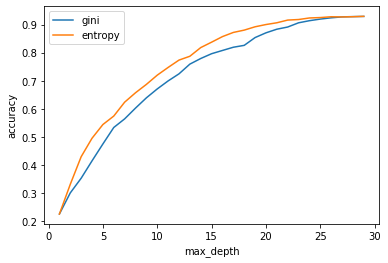

In [315]:
# visualizing changes in parameters
import matplotlib.pyplot as plt
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

* From the above we can see that entropy criterion has better accuracy but both curves intersect when the max_depth increases so we will choose criterion = entropy because of shorter training time and max depth = 27

### Building Final Model

In [318]:
%%time
#final model for prediction
clf=tree.DecisionTreeClassifier(criterion="entropy",max_depth=27).fit(train,train_y) # for cart criterian = entropy
predicted= clf.predict(test)

Wall time: 13.6 s


In [407]:
## predicting With Final Model

In [319]:
# Adding Predicted Variety colum in text data.
data2["variety"] = predicted

In [320]:
data2.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars,Pinot Noir
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards,Malbec
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime,Chardonnay
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio,Malbec
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole,Sangiovese


In [323]:
data2.to_csv("predicted.csv",index=False)